In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import traceback

# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp
import xobjects as xo


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.Progress as pbar
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst

# JOB imports
import importlib
sys.path.append('../../')
main_002 = importlib.import_module('Jobs.002_user_specific_tasks.main')
main = importlib.import_module('Jobs.003_particle_dist_and_track.main')







BUNCH = 202
tracking_path = f'zfruits/BBB_Signature/FULL/BUNCH_{str(BUNCH).zfill(4)}'
tracked   = xPlus.Tracking_Interface.from_parquet(tracking_path ,partition_name='CHUNK',
                    start_at_turn = 10000,
                    stop_at_turn  = 11000)

trk0   = xPlus.Tracking_Interface.from_parquet(tracking_path ,partition_name='CHUNK',
                    start_at_turn = 0,
                    stop_at_turn  = 10)


data_path = 'zfruits/BBB_Signature/DATA'
data      = xPlus.Tracking_Interface.from_parquet(data_path,partition_name='BUNCH',partition_ID=str(BUNCH).zfill(4))

tracked._data = data.data



---
# Finding lost particles
---

In [10]:
tracked.data

,BUNCH,Chunk ID,particle,state,start_at_turn,stop_at_turn,x_min,x_max,y_min,y_max,skew_min,skew_max,zeta_min,zeta_max,px_min,px_max,py_min,py_max,pzeta_min,pzeta_max
0,202,0,0,1,0,450,-0.000270,0.000278,-0.000419,0.000386,-0.000423,0.000425,-0.012766,0.013177,-0.000004,0.000004,-0.000008,0.000007,-0.000016,0.000018
1,202,0,1,1,0,450,-0.000669,0.000693,-0.000476,0.000465,-0.000777,0.000766,-0.140080,0.146015,-0.000010,0.000010,-0.000009,0.000010,-0.000172,0.000174
2,202,0,2,1,0,450,-0.000831,0.000882,-0.000234,0.000232,-0.000778,0.000798,-0.144000,0.185502,-0.000013,0.000012,-0.000004,0.000004,-0.000210,0.000213
3,202,0,3,1,0,450,-0.000329,0.000341,-0.000532,0.000528,-0.000557,0.000518,-0.187879,0.183830,-0.000005,0.000005,-0.000010,0.000010,-0.000213,0.000214
4,202,0,4,1,0,450,-0.001023,0.001077,-0.000372,0.000367,-0.000992,0.001006,-0.111381,0.108774,-0.000015,0.000016,-0.000007,0.000007,-0.000135,0.000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,202,49,19995,1,22041,22490,-0.000067,0.000081,-0.000553,0.000552,-0.000361,0.000350,-0.106899,0.106910,-0.000001,0.000001,-0.000010,0.000010,-0.000130,0.000131
999996,202,49,19996,1,22041,22490,-0.000522,0.000547,-0.000501,0.000492,-0.000680,0.000688,-0.046443,0.046454,-0.000008,0.000008,-0.000009,0.000009,-0.000057,0.000059
999997,202,49,19997,1,22041,22490,-0.001076,0.001150,-0.000311,0.000309,-0.001001,0.000997,-0.077323,0.076967,-0.000016,0.000017,-0.000006,0.000006,-0.000095,0.000097
999998,202,49,19998,1,22041,22490,-0.000126,0.000210,-0.000361,0.000366,-0.000298,0.000359,-0.290194,0.289858,-0.000003,0.000002,-0.000007,0.000007,-0.000034,0.000284


In [13]:
coll_x = 2.602e-3/2
coll_y = 1.86e-3/2
coll_s = 2.189e-3/2


def lost_condition(x_min,y_min,skew_min,x_max,y_max,skew_max):
    # y_fun_skew = lambda _x: np.tan(np.deg2rad(skew_angle))*_x + coll_s/np.cos(np.deg2rad(180-skew_angle))
    # np.abs(y)>y_fun_skew(np.abs(x)))
    return (np.abs(x_min)>coll_x)|(np.abs(y_min)>coll_y)|(np.abs(x_max)>coll_x)|(np.abs(y_max)>coll_y) |(np.abs(skew_max)>coll_s) |(np.abs(skew_min)>coll_s)

# Intensity = {}
# survived  = {}



_lost  = lost_condition(tracked.data.x_min,tracked.data.y_min,tracked.data.skew_min,tracked.data.x_max,tracked.data.y_max,tracked.data.skew_max)
idx_lost     = tracked.data.index[_lost]
idx_survived = tracked.data.index[~_lost]


# New columns
try:
    tracked.data.insert(0,'beyond_coll',False)
    tracked.data.insert(0,'lost',False)
except:
    tracked.data.loc[:,'beyond_coll'] = False
    tracked.data.loc[:,'lost'] = False



tracked.data.loc[idx_lost,'beyond_coll'] = True
tracked.data.loc[:,'lost'] = tracked.data.groupby('particle').beyond_coll.cumsum().astype(bool)

Intensity= tracked.data[~tracked.data.lost].groupby('start_at_turn').count().lost
survived  = tracked.data[~tracked.data.lost].groupby('start_at_turn').get_group(tracked.data.start_at_turn.max()).particle


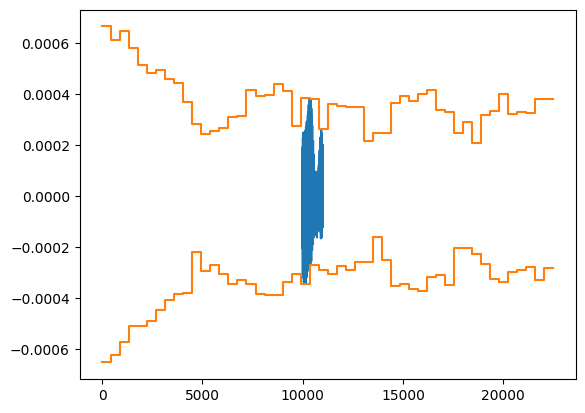

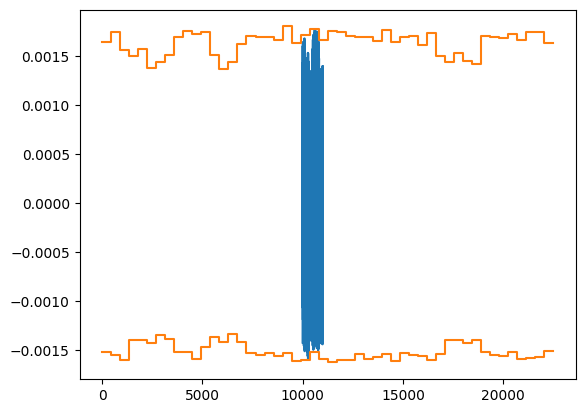

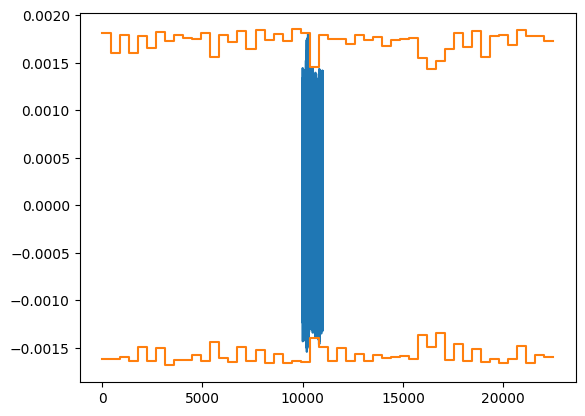

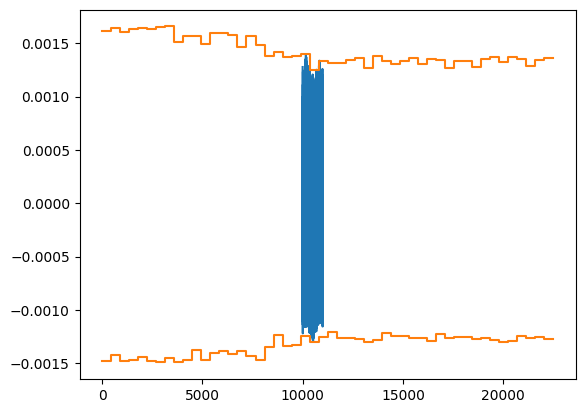

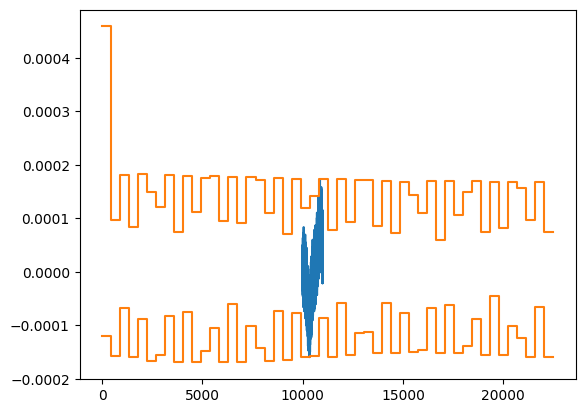

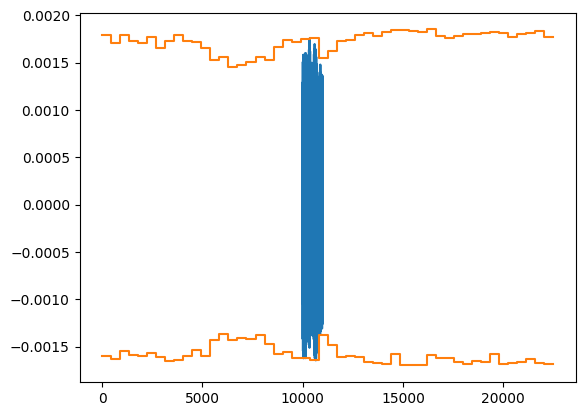

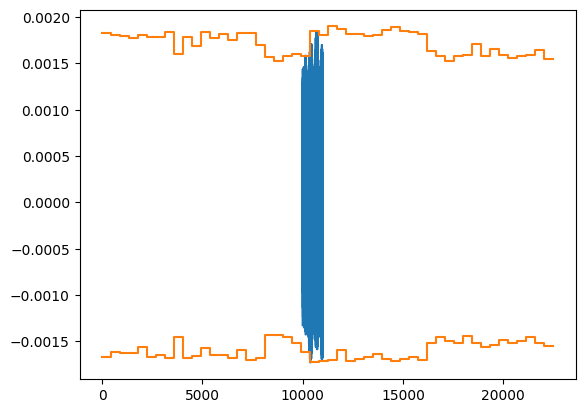

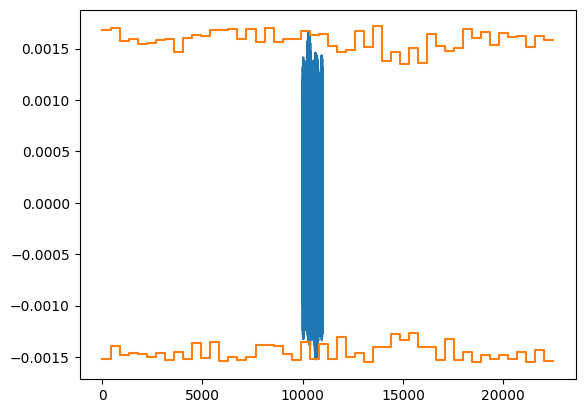

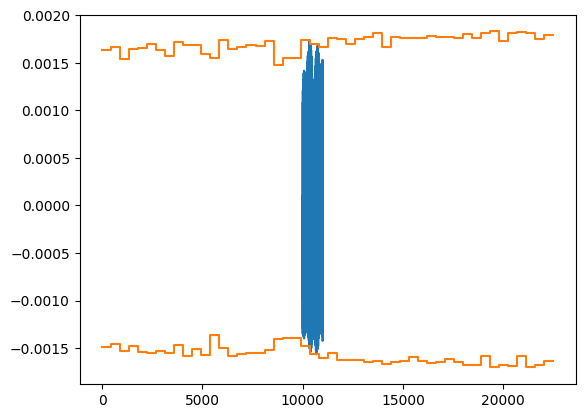

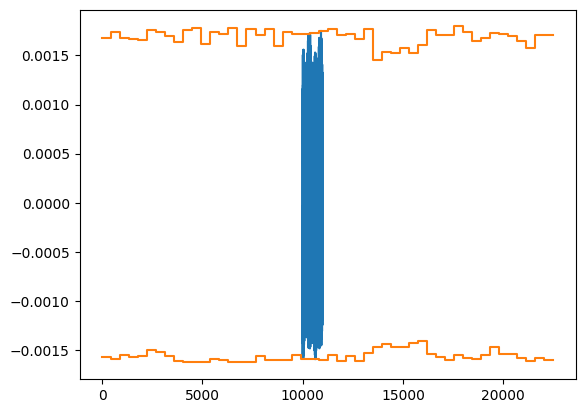

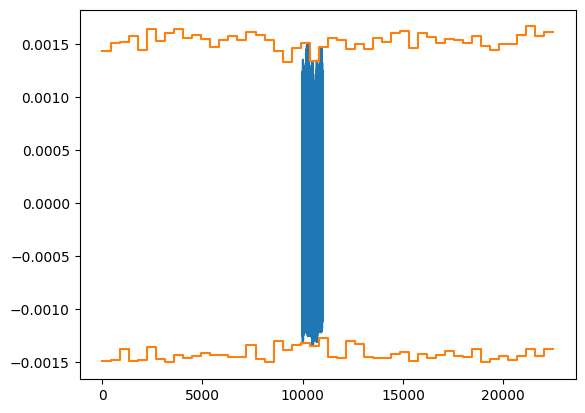

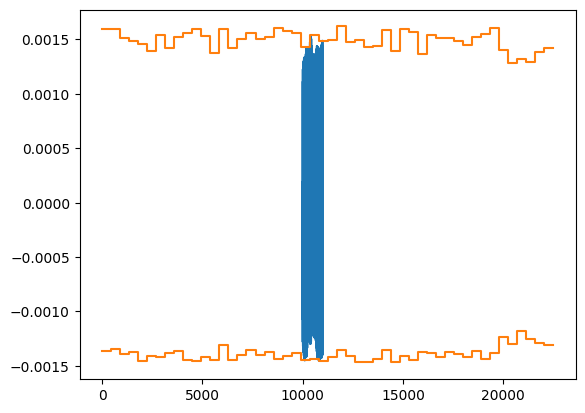

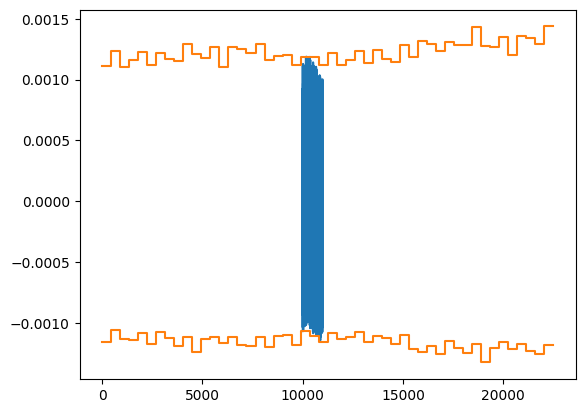

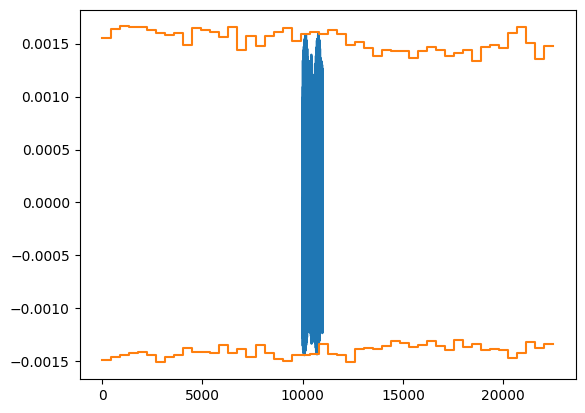

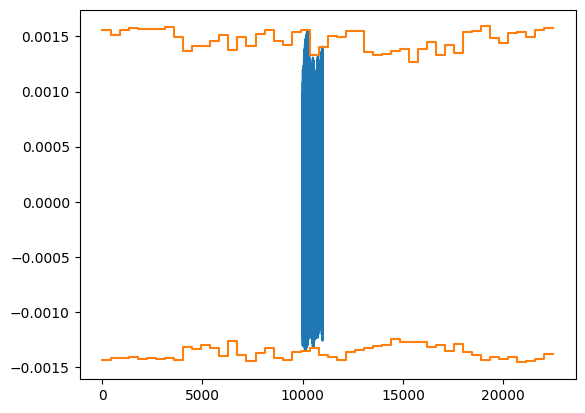

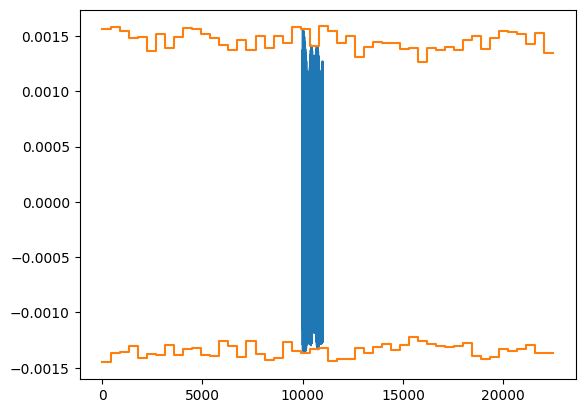

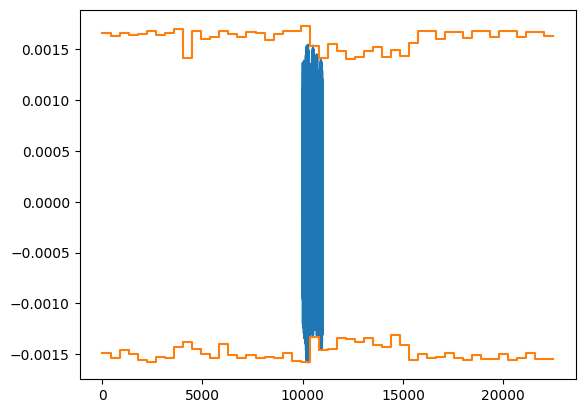

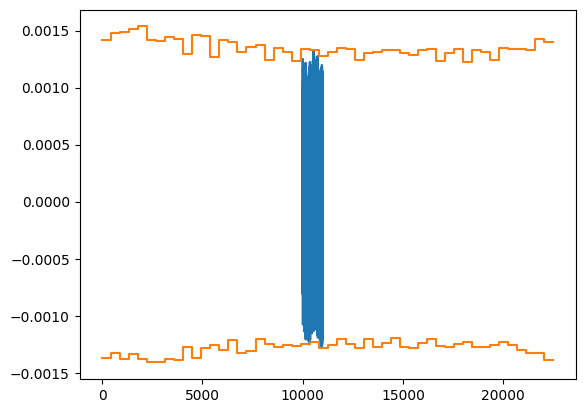

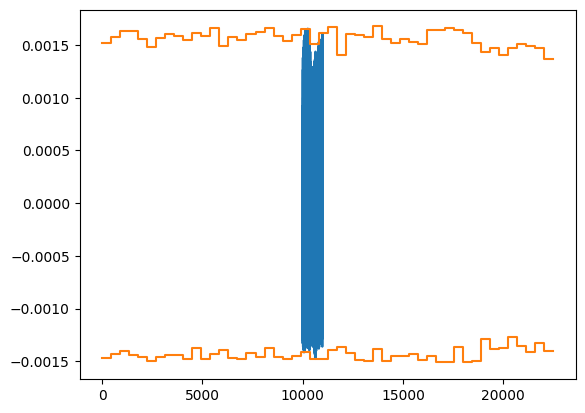

In [6]:


worst_particles = tracked.data.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index

for part_ID in worst_particles[1:20]:
# for part_ID in np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = tracked.data.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')



In [37]:
tracked.data

,lost,beyond_coll,BUNCH,Chunk ID,particle,state,start_at_turn,stop_at_turn,x_min,x_max,...,skew_min,skew_max,zeta_min,zeta_max,px_min,px_max,py_min,py_max,pzeta_min,pzeta_max
0,False,False,202,0,0,1,0,450,-0.000270,0.000278,...,-0.000423,0.000425,-0.012766,0.013177,-0.000004,0.000004,-0.000008,0.000007,-0.000016,0.000018
1,False,False,202,0,1,1,0,450,-0.000669,0.000693,...,-0.000777,0.000766,-0.140080,0.146015,-0.000010,0.000010,-0.000009,0.000010,-0.000172,0.000174
2,False,False,202,0,2,1,0,450,-0.000831,0.000882,...,-0.000778,0.000798,-0.144000,0.185502,-0.000013,0.000012,-0.000004,0.000004,-0.000210,0.000213
3,False,False,202,0,3,1,0,450,-0.000329,0.000341,...,-0.000557,0.000518,-0.187879,0.183830,-0.000005,0.000005,-0.000010,0.000010,-0.000213,0.000214
4,False,False,202,0,4,1,0,450,-0.001023,0.001077,...,-0.000992,0.001006,-0.111381,0.108774,-0.000015,0.000016,-0.000007,0.000007,-0.000135,0.000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,False,False,202,49,19995,1,22041,22490,-0.000067,0.000081,...,-0.000361,0.000350,-0.106899,0.106910,-0.000001,0.000001,-0.000010,0.000010,-0.000130,0.000131
999996,False,False,202,49,19996,1,22041,22490,-0.000522,0.000547,...,-0.000680,0.000688,-0.046443,0.046454,-0.000008,0.000008,-0.000009,0.000009,-0.000057,0.000059
999997,False,False,202,49,19997,1,22041,22490,-0.001076,0.001150,...,-0.001001,0.000997,-0.077323,0.076967,-0.000016,0.000017,-0.000006,0.000006,-0.000095,0.000097
999998,False,False,202,49,19998,1,22041,22490,-0.000126,0.000210,...,-0.000298,0.000359,-0.290194,0.289858,-0.000003,0.000002,-0.000007,0.000007,-0.000034,0.000284


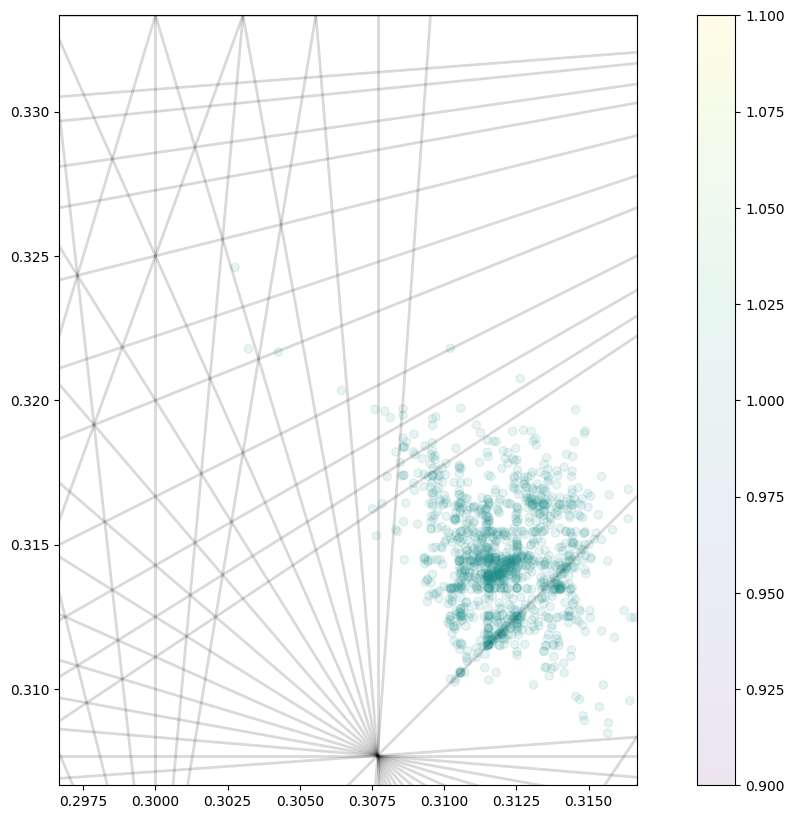

In [44]:

# chosen = trk0.coord_sig.particle.unique()
chosen = (tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').lost)
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.y_sig**2<1**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.px_sig**2<2**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.y_sig**2+trk0.coord_sig.py_sig**2<4].particle.unique()

plt.figure(figsize=(10,10))

# TEMPLATE FP PLT
#============================
window = 0.02
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
Qy_lim    = [Qy_0-4*window/6,Qy_0+4*window/6]


bbplt.workingDiagram(order=15,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [0,0],alpha=0.15,color='k',lw=2)

# plt.plot(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],'.',alpha=0.1,color='C0')
# plt.scatter(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],c=trk0.coord_sig.set_index('particle').loc[chosen,'x_sig'],alpha=0.3)
plt.scatter(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],c=tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').loc[chosen,'lost'],alpha=0.1)
plt.colorbar()

# h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
plt.axis('square')
plt.xlim(np.array(Qx_lim));
plt.ylim(np.array(Qy_lim));
#==============================




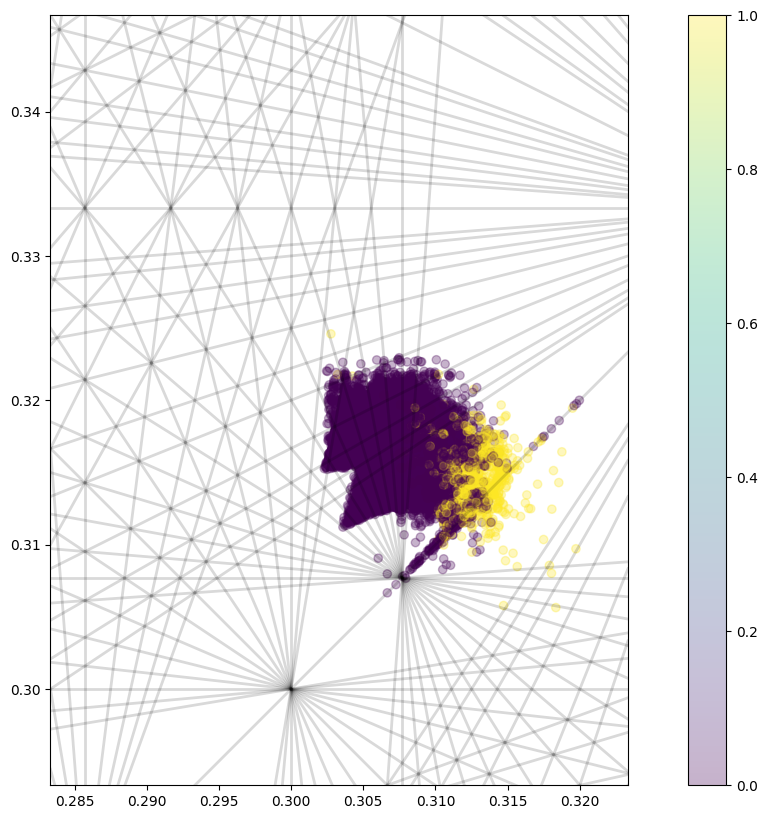

In [26]:

chosen = trk0.coord_sig.particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.y_sig**2<1**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.px_sig**2<2**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.y_sig**2+trk0.coord_sig.py_sig**2<4].particle.unique()

plt.figure(figsize=(10,10))

# TEMPLATE FP PLT
#============================
window = 0.04
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
Qy_lim    = [Qy_0-4*window/6,Qy_0+4*window/6]


bbplt.workingDiagram(order=15,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [0,0],alpha=0.15,color='k',lw=2)

# plt.plot(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],'.',alpha=0.1,color='C0')
plt.scatter(tracked.tunes_n.Qx.loc[chosen],tracked.tunes_n.Qy.loc[chosen],c=tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').loc[chosen,'lost'],alpha=0.3)
plt.colorbar()

# h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
plt.axis('square')
plt.xlim(np.array(Qx_lim));
plt.ylim(np.array(Qy_lim));
#==============================


